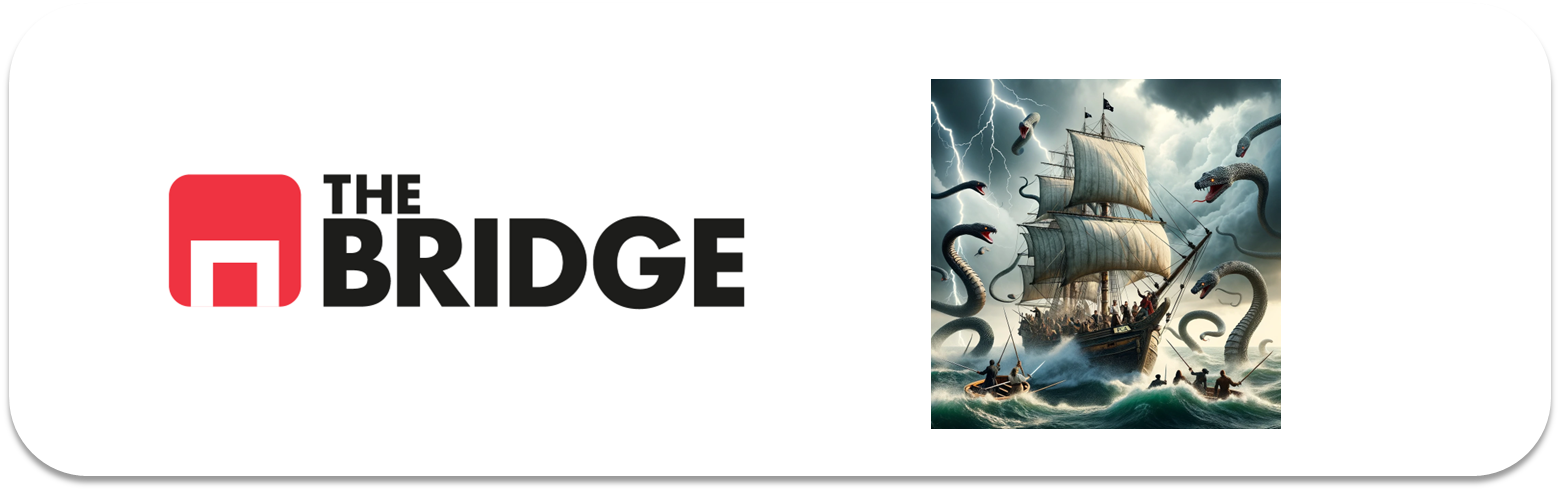

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from lightgbm import LGBMClassifier
from scipy.stats import mannwhitneyu 
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, RFE, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, mutual_info_score

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


*Modelo supervisado de clasificación -> target. Predecir la posible deuda de más de 90 días en los próximos dos años*

## 1. Nulos y features

In [2]:
df = pd.read_csv("./data/credit_npo.csv")
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [4]:
df.dropna(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

In [6]:
target = "SeriousDlqin2yrs"

In [7]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

## 2. MiniEDA

1. Análisis visual, filtrado por valores de correlación y umbral de varianza

*Target*

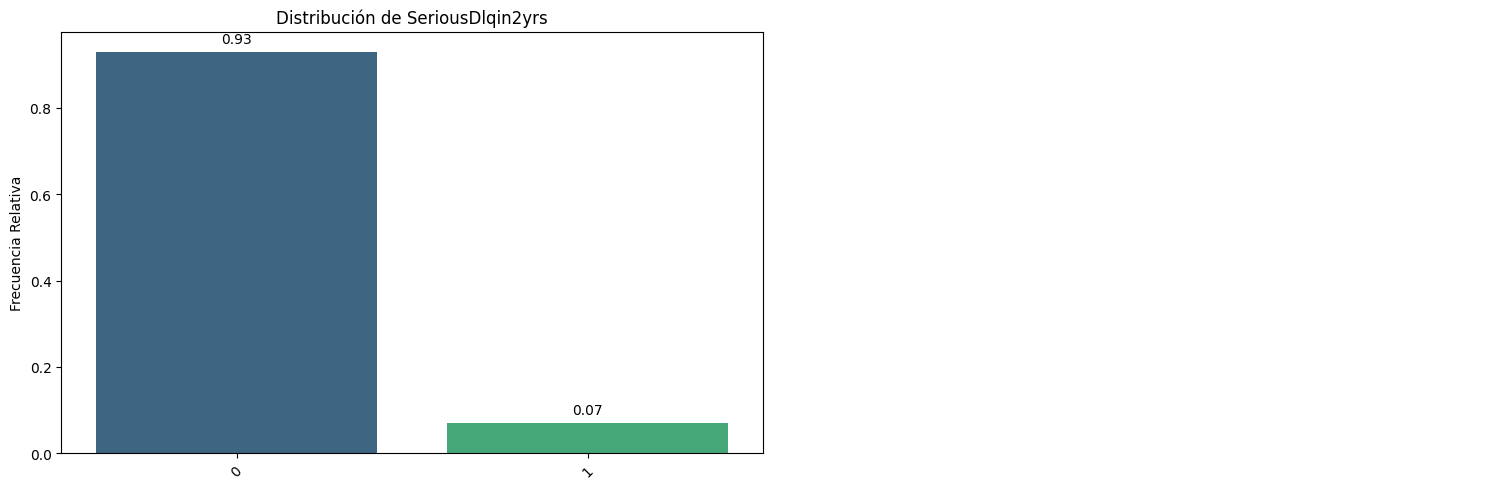

In [8]:
bt.pinta_distribucion_categoricas(train_set, [target], mostrar_valores=True, relativa=True)

*El target está muy desequilibrado*

In [9]:
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,9452.0,0.070144,0.255403,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,9452.0,0.335207,0.362233,0.0,0.034869,0.179211,0.587533,6.0
age,9452.0,51.491536,14.499298,21.0,41.000000,51.000000,62.000000,101.0
NumberOfTime30-59DaysPastDueNotWorse,9452.0,0.343314,2.930489,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,9452.0,0.486047,2.505031,0.0,0.146204,0.297564,0.477876,96.0
MonthlyIncome,9452.0,6868.428058,12580.543336,0.0,3466.000000,5441.000000,8300.000000,702500.0
NumberOfOpenCreditLinesAndLoans,9452.0,8.794647,5.139555,0.0,5.000000,8.000000,11.000000,49.0
NumberOfTimes90DaysLate,9452.0,0.180279,2.889984,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,9452.0,1.064325,1.148156,0.0,0.000000,1.000000,2.000000,19.0
NumberOfTime60-89DaysPastDueNotWorse,9452.0,0.152772,2.870119,0.0,0.000000,0.000000,0.000000,98.0


(10, 2)


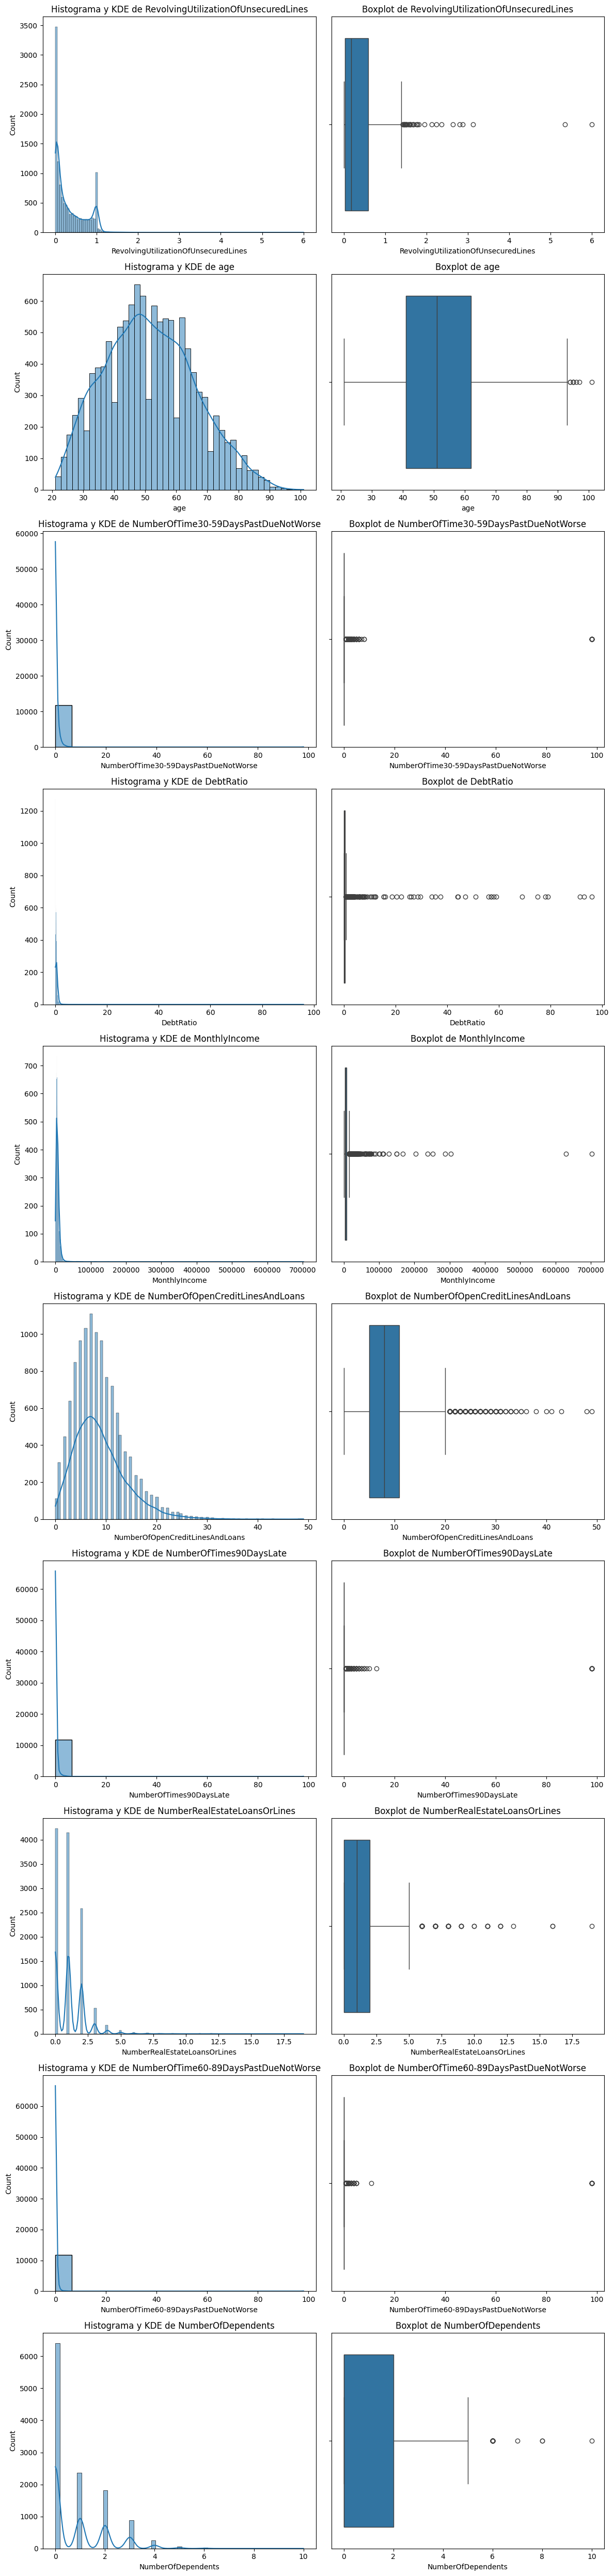

In [10]:
bt.plot_combined_graphs(df, [col for col in df.columns if col != target])

In [11]:
train_set["NumberOfTime30-59DaysPastDueNotWorse"].value_counts(normalize=True)*100

NumberOfTime30-59DaysPastDueNotWorse
0     83.114685
1     11.352095
2      3.364367
3      1.089716
4      0.560728
5      0.211595
6      0.190436
98     0.084638
8      0.021160
7      0.010580
Name: proportion, dtype: float64

In [12]:
def categorize_30_59(x):
    if x == 0:
        return 0
    elif x == 1:
        return 1
    else:
        return 2

In [55]:
train_set["N30-59"] = train_set["NumberOfTime30-59DaysPastDueNotWorse"].apply(categorize_30_59).astype(int)
test_set["N30-59"] = test_set["NumberOfTime30-59DaysPastDueNotWorse"].apply(categorize_30_59).astype(int)

In [14]:
train_set["N30-59"].value_counts(True)

N30-59
0    0.831147
1    0.113521
2    0.055332
Name: proportion, dtype: float64

In [15]:
train_set.NumberOfOpenCreditLinesAndLoans.value_counts(normalize=True)*100 #numérica

NumberOfOpenCreditLinesAndLoans
7     9.363098
8     8.601354
6     8.527296
9     8.082945
5     8.072366
4     7.289463
10    6.527719
11    6.093948
3     5.374524
12    4.803216
13    3.925095
2     3.639441
14    3.184511
15    2.930597
1     2.623783
16    2.031316
17    1.893779
18    1.248413
19    1.142615
20    0.973339
0     0.920440
21    0.528989
22    0.518409
24    0.359712
23    0.317393
25    0.253915
26    0.158697
27    0.126957
28    0.105798
31    0.074058
29    0.074058
30    0.063479
33    0.042319
32    0.031739
35    0.021160
34    0.021160
48    0.010580
40    0.010580
41    0.010580
49    0.010580
36    0.010580
Name: proportion, dtype: float64

In [16]:
train_set["NumberOfTime60-89DaysPastDueNotWorse"].value_counts(normalize=True)*100

NumberOfTime60-89DaysPastDueNotWorse
0     94.720694
1      4.052052
2      0.804063
3      0.148117
4      0.137537
98     0.084638
5      0.042319
11     0.010580
Name: proportion, dtype: float64

In [54]:
train_set["N60-89"] = (train_set["NumberOfTime60-89DaysPastDueNotWorse"] >0).astype(int)
test_set["N60-89"] = (test_set["NumberOfTime60-89DaysPastDueNotWorse"] >0).astype(int)

In [18]:
train_set["N60-89"].value_counts(True)*100

N60-89
0    94.720694
1     5.279306
Name: proportion, dtype: float64

In [19]:
train_set["NumberOfTimes90DaysLate"].value_counts(normalize=True)*100

NumberOfTimes90DaysLate
0     94.360982
1      3.311468
2      1.258993
3      0.465510
4      0.275074
5      0.148117
98     0.084638
6      0.052899
7      0.021160
9      0.010580
10     0.010580
Name: proportion, dtype: float64

In [56]:
train_set["N90"] = (train_set["NumberOfTimes90DaysLate"] >0).astype(int)
test_set["N90"] = (test_set["NumberOfTimes90DaysLate"] >0).astype(int)

In [21]:
train_set["N90"].value_counts(True)*100

N90
0    94.360982
1     5.639018
Name: proportion, dtype: float64

In [22]:
train_set["NumberOfDependents"].value_counts(normalize=True)*100 #la dejo así

NumberOfDependents
0.0     54.221329
1.0     19.942869
2.0     15.308929
3.0      7.490478
4.0      2.211172
5.0      0.581887
6.0      0.201016
8.0      0.021160
7.0      0.010580
10.0     0.010580
Name: proportion, dtype: float64

| Columna | Tipo |
|---------|-------|
| RevolvingUtilizationOfUnsecuredLines | Numérica continua |
| age | Numérica continua |
| NumberOfTime30-59DaysPastDueNotWorse | Categórica |
| DebtRatio | Numérica continua |
| MonthlyIncome | Numérica continua |
| NumberOfOpenCreditLinesAndLoans | Numérica discreta |
| NumberRealEstateLoansOrLines | Numérica |
| NumberOfTime60-89DaysPastDueNotWorse | Categórica |
| NumberOfTimes90DaysLate | Categórica |
| NumberOfDependents | Numérica |

In [23]:
features_num=["RevolvingUtilizationOfUnsecuredLines",
              "age",
              "DebtRatio",
              "MonthlyIncome",
              "NumberOfOpenCreditLinesAndLoans",
              "NumberRealEstateLoansOrLines",
              "NumberOfDependents"]

In [24]:
features_cat=["N30-59",
              "N60-89",
              "N90"]

*Análisis visual*

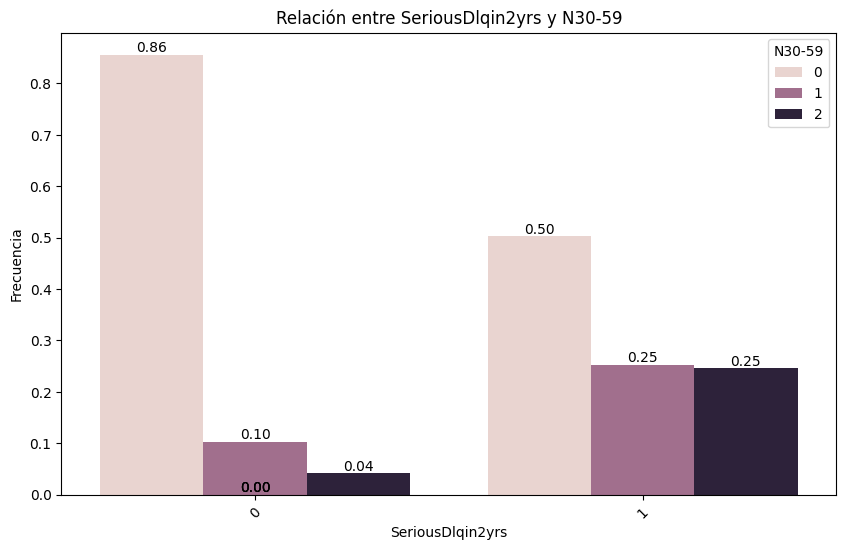

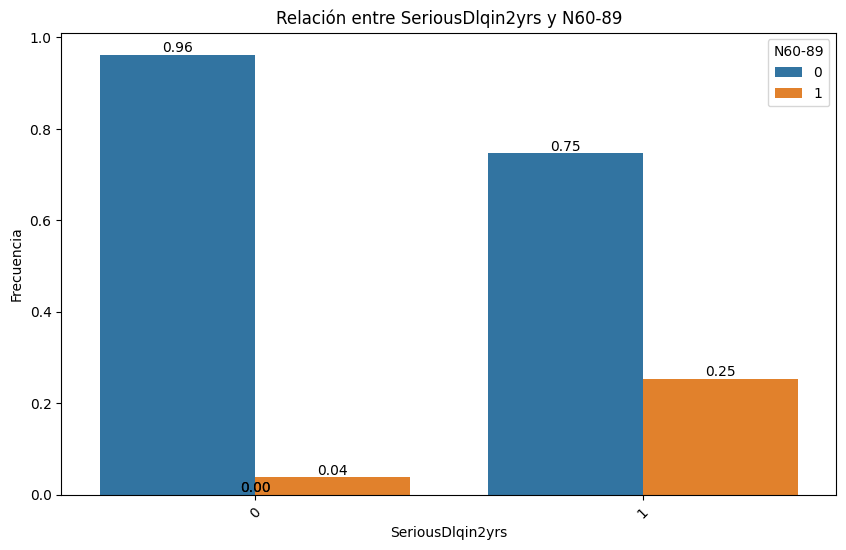

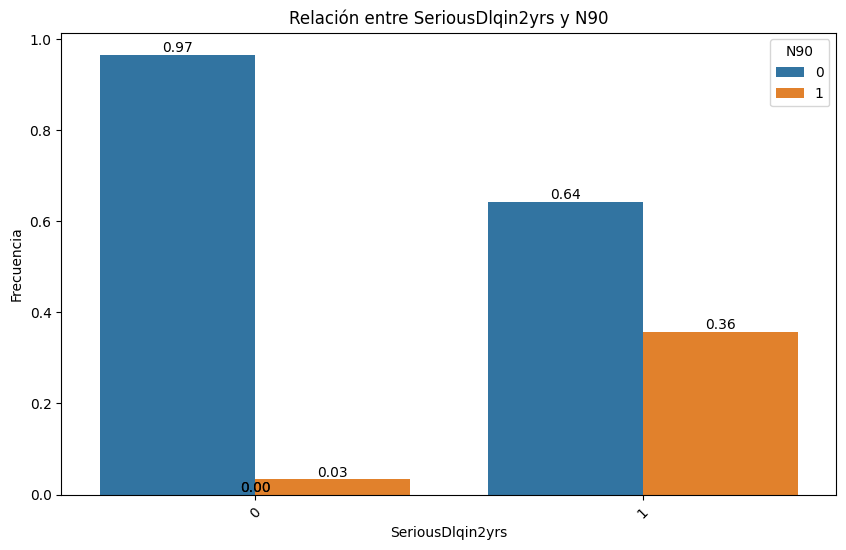

In [25]:
for col in features_cat:
    bt.plot_categorical_relationship_fin(train_set, target, col, show_values=True, relative_freq=True)

In [26]:
features_sel= features_cat.copy()

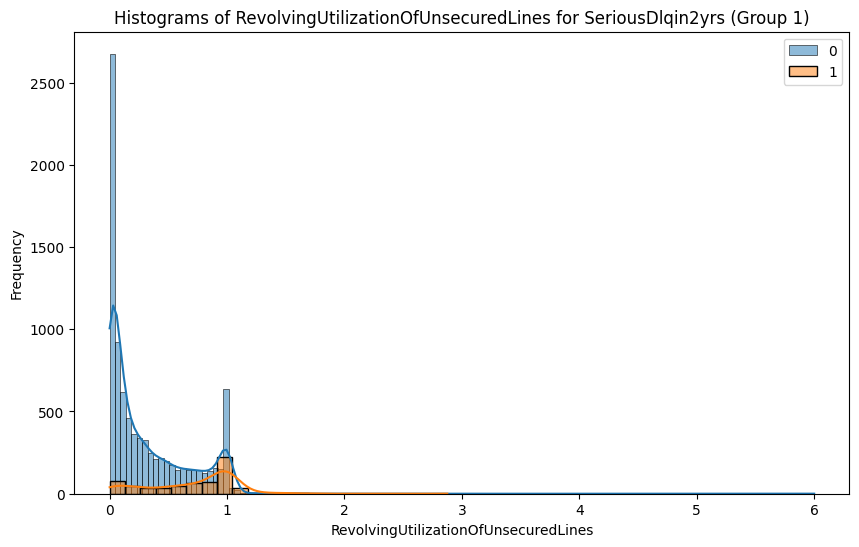

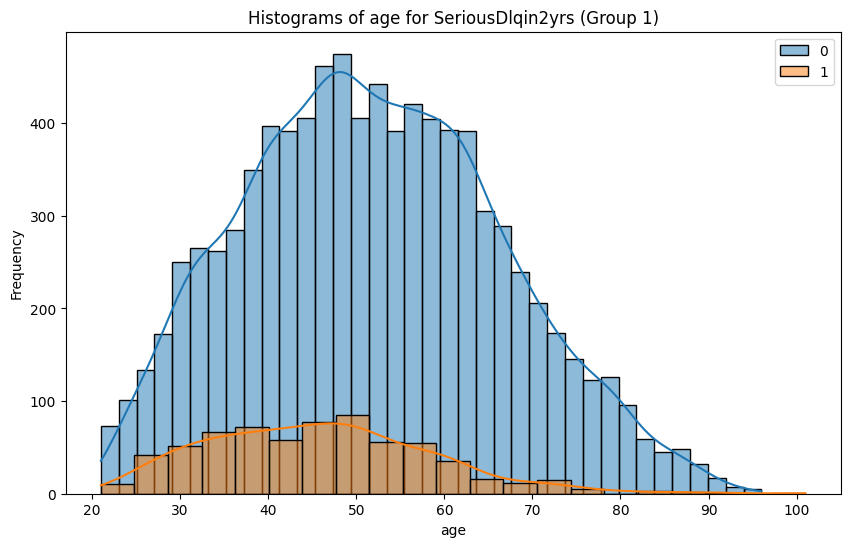

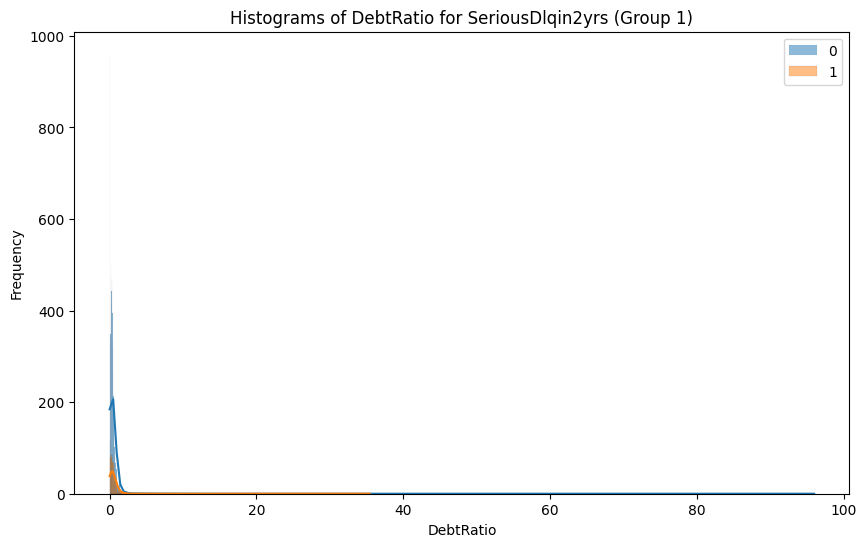

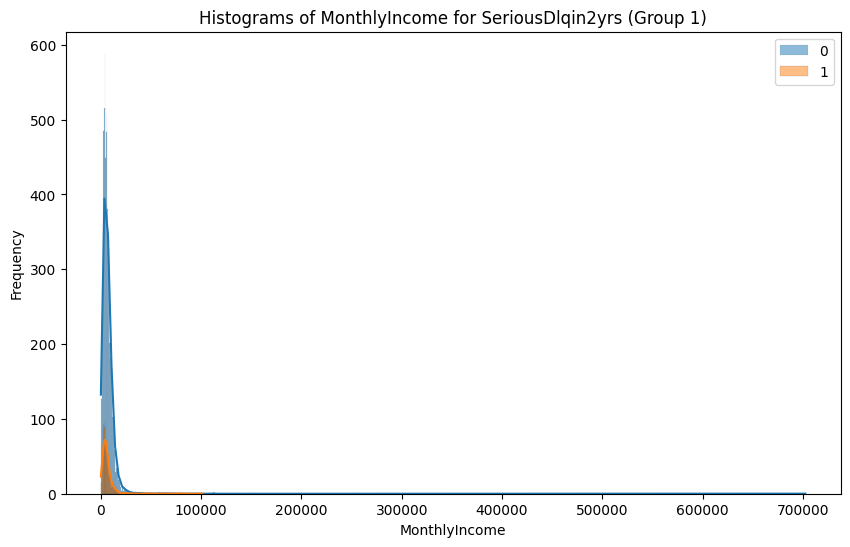

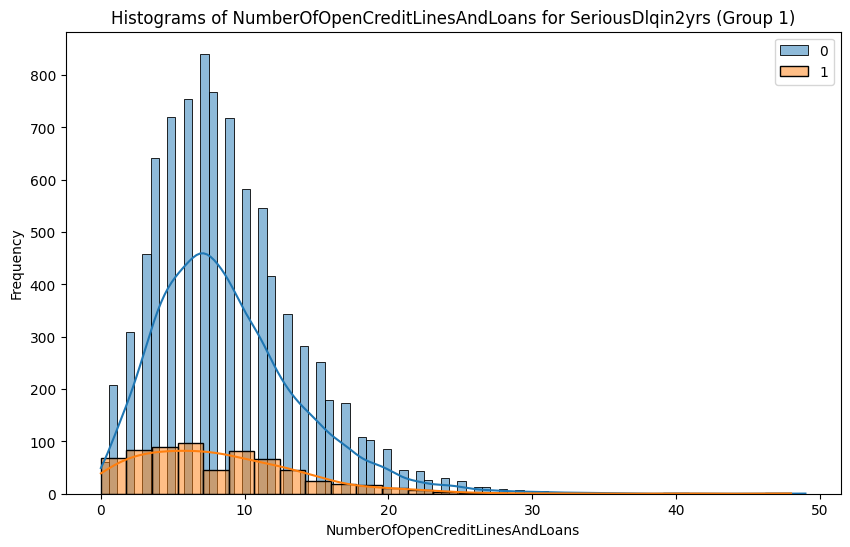

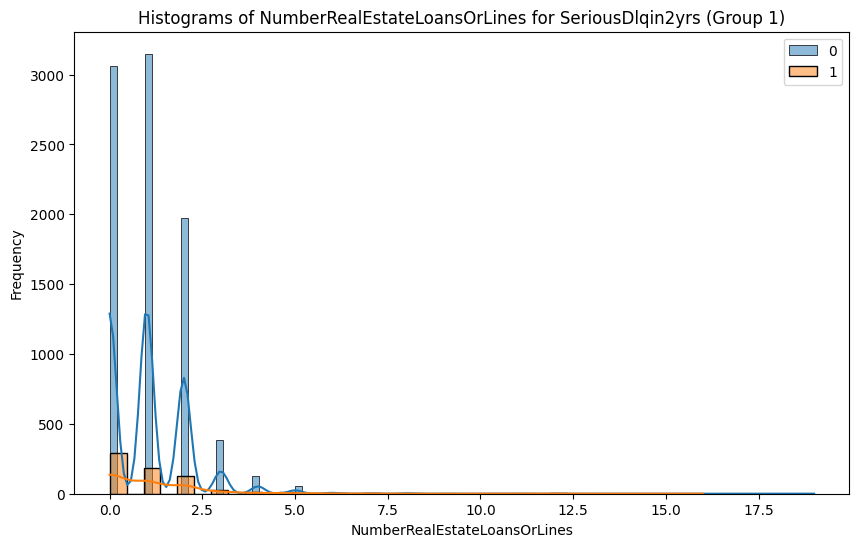

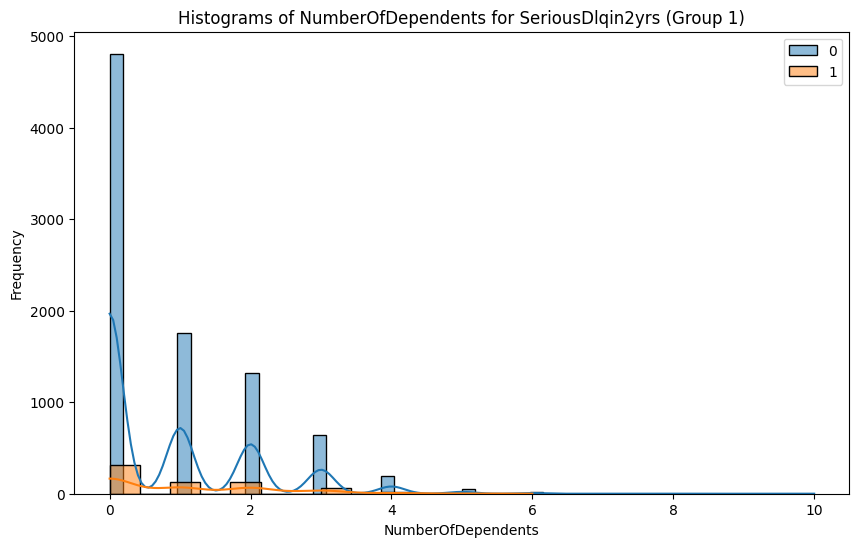

In [27]:
for col in features_num:
    bt.plot_grouped_histograms(train_set, cat_col=target, num_col=col, group_size=2)

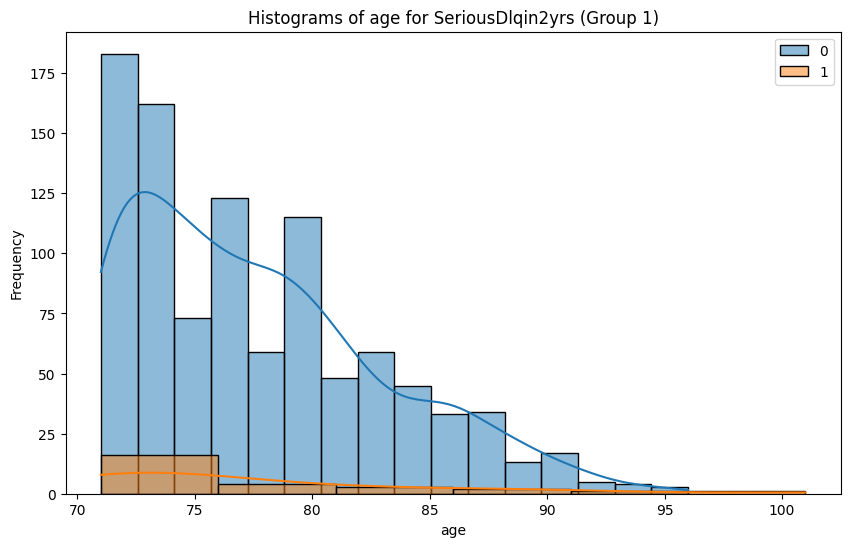

In [28]:
#age
bt.plot_grouped_histograms(train_set[train_set["age"]>70], cat_col=target, num_col="age", group_size=2)

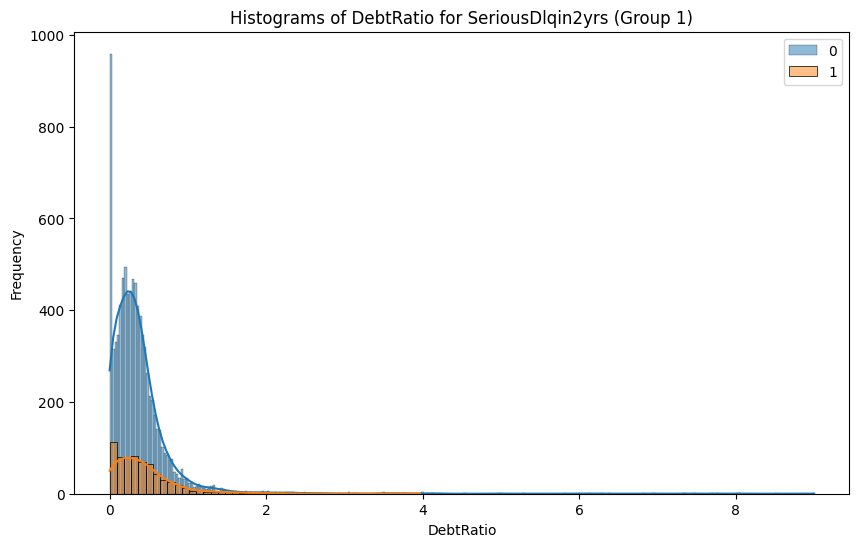

In [29]:
#DebtRatio
bt.plot_grouped_histograms(train_set[train_set["DebtRatio"]<10], cat_col=target, num_col="DebtRatio", group_size=2)

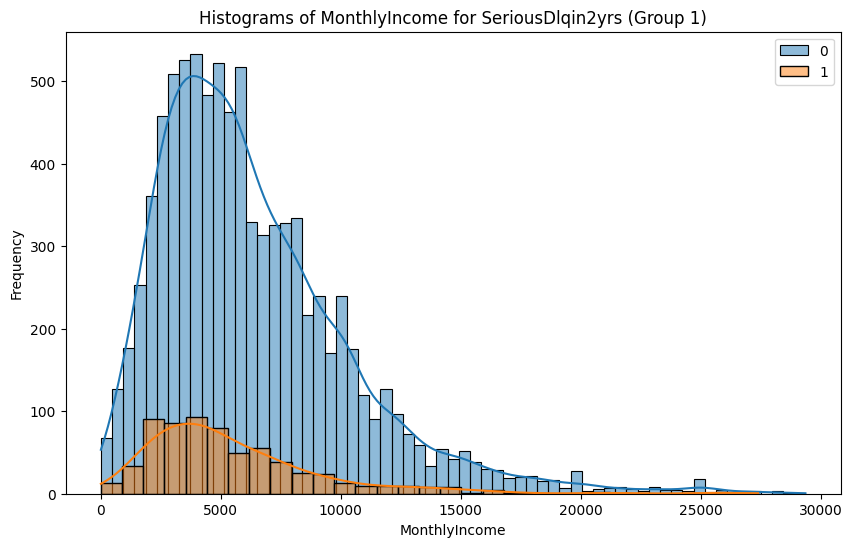

In [30]:
#MonthlyIncome
bt.plot_grouped_histograms(train_set[train_set["MonthlyIncome"]<30000], cat_col=target, num_col="MonthlyIncome", group_size=2)

*Test U de Mann-Whitney*

In [31]:
for col in features_num:
    grupo_a = train_set.loc[train_set[target]==0][col]
    grupo_b = train_set.loc[train_set[target]==1][col]

    u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

    print(col)
    print("Estadístico U:", u_stat)
    print("p_valor:", p_valor)
    print("")

RevolvingUtilizationOfUnsecuredLines
Estadístico U: 1290506.0
p_valor: 6.964140175938447e-127

age
Estadístico U: 3637144.5
p_valor: 1.2329564748313774e-26

DebtRatio
Estadístico U: 2623985.5
p_valor: 1.920288228898668e-05

MonthlyIncome
Estadístico U: 3309844.0
p_valor: 4.937655211085432e-09

NumberOfOpenCreditLinesAndLoans
Estadístico U: 3186861.0
p_valor: 5.276240582379398e-05

NumberRealEstateLoansOrLines
Estadístico U: 3107009.0
p_valor: 0.002619617920579262

NumberOfDependents
Estadístico U: 2672057.5
p_valor: 9.015679141107874e-05



In [32]:
features_sel.append("RevolvingUtilizationOfUnsecuredLines")
features_sel.append("age")
features_sel.append("MonthlyIncome")
features_sel.append("DebtRatio")

*Umbral de varianza*

In [33]:
for umbral in np.arange(0,1,0.1):
    print("Umbral:", umbral)
    selector = VarianceThreshold(threshold=umbral)
    selector.fit(train_set[features_num])
    print(selector.get_feature_names_out())


Umbral: 0.0
['RevolvingUtilizationOfUnsecuredLines' 'age' 'DebtRatio' 'MonthlyIncome'
 'NumberOfOpenCreditLinesAndLoans' 'NumberRealEstateLoansOrLines'
 'NumberOfDependents']
Umbral: 0.1
['RevolvingUtilizationOfUnsecuredLines' 'age' 'DebtRatio' 'MonthlyIncome'
 'NumberOfOpenCreditLinesAndLoans' 'NumberRealEstateLoansOrLines'
 'NumberOfDependents']
Umbral: 0.2
['age' 'DebtRatio' 'MonthlyIncome' 'NumberOfOpenCreditLinesAndLoans'
 'NumberRealEstateLoansOrLines' 'NumberOfDependents']
Umbral: 0.30000000000000004
['age' 'DebtRatio' 'MonthlyIncome' 'NumberOfOpenCreditLinesAndLoans'
 'NumberRealEstateLoansOrLines' 'NumberOfDependents']
Umbral: 0.4
['age' 'DebtRatio' 'MonthlyIncome' 'NumberOfOpenCreditLinesAndLoans'
 'NumberRealEstateLoansOrLines' 'NumberOfDependents']
Umbral: 0.5
['age' 'DebtRatio' 'MonthlyIncome' 'NumberOfOpenCreditLinesAndLoans'
 'NumberRealEstateLoansOrLines' 'NumberOfDependents']
Umbral: 0.6000000000000001
['age' 'DebtRatio' 'MonthlyIncome' 'NumberOfOpenCreditLinesAndLoans

In [34]:
for umbral in np.arange(0,1,0.1):
    print("Umbral:", umbral)
    selector = VarianceThreshold(threshold=umbral)
    selector.fit(train_set[features_sel])
    print(selector.get_feature_names_out())

Umbral: 0.0
['N30-59' 'N60-89' 'N90' 'RevolvingUtilizationOfUnsecuredLines' 'age'
 'MonthlyIncome' 'DebtRatio']
Umbral: 0.1
['N30-59' 'RevolvingUtilizationOfUnsecuredLines' 'age' 'MonthlyIncome'
 'DebtRatio']
Umbral: 0.2
['N30-59' 'age' 'MonthlyIncome' 'DebtRatio']
Umbral: 0.30000000000000004
['age' 'MonthlyIncome' 'DebtRatio']
Umbral: 0.4
['age' 'MonthlyIncome' 'DebtRatio']
Umbral: 0.5
['age' 'MonthlyIncome' 'DebtRatio']
Umbral: 0.6000000000000001
['age' 'MonthlyIncome' 'DebtRatio']
Umbral: 0.7000000000000001
['age' 'MonthlyIncome' 'DebtRatio']
Umbral: 0.8
['age' 'MonthlyIncome' 'DebtRatio']
Umbral: 0.9
['age' 'MonthlyIncome' 'DebtRatio']


*No nos ayuda demasiado, ya que no son variables continuas todas*

In [35]:
features_sel

['N30-59',
 'N60-89',
 'N90',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'MonthlyIncome',
 'DebtRatio']

2. Selección por filtrado, ANOVA y Mutal Information

*Numéricas*

In [36]:
X_train= train_set[features_num]
y_train = train_set[target]

selector= SelectKBest(k=4)
X_kbest= selector.fit_transform(X_train,y_train)
X_train_kbest = pd.DataFrame(X_kbest, columns=selector.get_feature_names_out())
X_train_kbest

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfOpenCreditLinesAndLoans,NumberOfDependents
0,0.391240,68.0,13.0,0.0
1,0.906540,59.0,7.0,1.0
2,0.933223,52.0,3.0,3.0
3,0.857859,50.0,9.0,0.0
4,0.000000,61.0,5.0,1.0
...,...,...,...,...
9447,0.397822,53.0,14.0,0.0
9448,0.015171,76.0,4.0,0.0
9449,0.988201,62.0,4.0,0.0
9450,0.122072,41.0,9.0,1.0


In [37]:
features_filtradas= list(selector.get_feature_names_out())
features_filtradas

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents']

*Categóricas*

In [38]:
for col in features_cat:
    print(f"Mutual Information ({col} y {target}): {mutual_info_score(train_set[col], train_set[target])}")

Mutual Information (N30-59 y SeriousDlqin2yrs): 0.024765507782367968
Mutual Information (N60-89 y SeriousDlqin2yrs): 0.017771329855032478
Mutual Information (N90 y SeriousDlqin2yrs): 0.03421467132247159


In [39]:
features_filtradas += features_cat
features_filtradas

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents',
 'N30-59',
 'N60-89',
 'N90']

3. Selección mejores features - SelectFromModel

In [40]:
features = features_num + features_cat

rf_selector = RandomForestClassifier(random_state=42, class_weight="balanced")

selector = SelectFromModel(estimator= rf_selector, threshold="median")

selector.fit(train_set[features], train_set[target])
features_modelo = list(selector.get_feature_names_out())
features_modelo

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'N30-59']

4. Selección mejores features - RFE

In [41]:
rf_RFE = RandomForestClassifier(random_state=42, class_weight="balanced")

rfe = RFE(estimator= rf_RFE, n_features_to_select=6, step=1)

rfe.fit(train_set[features], train_set[target])

RFE(estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    n_features_to_select=6)

In [42]:
features_RFE = list(rfe.get_feature_names_out())
features_RFE

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'N30-59']

5. Selección mejores features - SFS

In [43]:
rf_SFS = RandomForestClassifier(random_state=42, class_weight="balanced")

sfs = SequentialFeatureSelector(rf_SFS, n_features_to_select=6, cv=4, scoring="balanced_accuracy", n_jobs=-1)

sfs.fit(train_set[features], train_set[target])

SequentialFeatureSelector(cv=4,
                          estimator=RandomForestClassifier(class_weight='balanced',
                                                           random_state=42),
                          n_features_to_select=6, n_jobs=-1,
                          scoring='balanced_accuracy')

In [44]:
features_SFS = list(sfs.get_feature_names_out())
features_SFS

['RevolvingUtilizationOfUnsecuredLines',
 'NumberRealEstateLoansOrLines',
 'NumberOfDependents',
 'N30-59',
 'N60-89',
 'N90']

6. Selección mejores features - HardVoting

In [45]:
todas_las_listas = features_sel + features_filtradas + features_modelo + features_RFE + features_SFS
conteo = Counter(todas_las_listas)
conteo

Counter({'N30-59': 5,
         'RevolvingUtilizationOfUnsecuredLines': 5,
         'age': 4,
         'N60-89': 3,
         'N90': 3,
         'MonthlyIncome': 3,
         'DebtRatio': 3,
         'NumberOfOpenCreditLinesAndLoans': 2,
         'NumberOfDependents': 2,
         'NumberRealEstateLoansOrLines': 1})

In [46]:
pd.DataFrame(conteo.values(), columns=["Votos"], index=conteo.keys()).sort_values(by="Votos",ascending=False)

,Votos
N30-59,5
RevolvingUtilizationOfUnsecuredLines,5
age,4
N60-89,3
N90,3
MonthlyIncome,3
DebtRatio,3
NumberOfOpenCreditLinesAndLoans,2
NumberOfDependents,2
NumberRealEstateLoansOrLines,1


In [49]:
features_hard_voting=["N30-59","RevolvingUtilizationOfUnsecuredLines", "age", "N60-89", "N90","MonthlyIncome","DebtRatio"]

## 3. Modelos

In [50]:
nombres = [f"Seleccion ({nombre})" for nombre in ["visual", "filtrado", "modelo", "rfe", "sfs", "hard_voting"]]
model_names = ["Random Forest", "XGBoost", "LightGBM"]

rf_clf = RandomForestClassifier(class_weight="balanced", random_state=42)
xg_clf = XGBClassifier(random_state=42, scale_pos_weight=len(train_set[train_set[target] == 0]) / len(train_set[train_set[target] == 1]))
lgb_clf = LGBMClassifier(class_weight="balanced", random_state=42, verbose=-100, n_jobs=-1)

models = [rf_clf, xg_clf, lgb_clf]
resultados = []

for indice, lista in enumerate([features_sel, features_filtradas, features_modelo, features_RFE, features_SFS, features_hard_voting]):
    X_train = train_set[lista]
    y_train = train_set[target]
    
    for model_name, modelo in zip(model_names, models):
        metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv=5, scoring="balanced_accuracy"))
        data = {
            "features_list": nombres[indice],
            "model": model_name,
            "avg. recall": metrica
        }
        print(data)
        resultados.append(data.copy())

df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by="avg. recall", ascending=False)

{'features_list': 'Seleccion (visual)', 'model': 'Random Forest', 'avg. recall': np.float64(0.5728532407129139)}
{'features_list': 'Seleccion (visual)', 'model': 'XGBoost', 'avg. recall': np.float64(0.6424797084147288)}
{'features_list': 'Seleccion (visual)', 'model': 'LightGBM', 'avg. recall': np.float64(0.718585685857393)}
{'features_list': 'Seleccion (filtrado)', 'model': 'Random Forest', 'avg. recall': np.float64(0.571761839906631)}
{'features_list': 'Seleccion (filtrado)', 'model': 'XGBoost', 'avg. recall': np.float64(0.6507265458983644)}
{'features_list': 'Seleccion (filtrado)', 'model': 'LightGBM', 'avg. recall': np.float64(0.7336713375413791)}
{'features_list': 'Seleccion (modelo)', 'model': 'Random Forest', 'avg. recall': np.float64(0.5303751415975057)}
{'features_list': 'Seleccion (modelo)', 'model': 'XGBoost', 'avg. recall': np.float64(0.6276511912856422)}
{'features_list': 'Seleccion (modelo)', 'model': 'LightGBM', 'avg. recall': np.float64(0.695997601643672)}
{'features_li

,features_list,model,avg. recall
14,Seleccion (sfs),LightGBM,0.737778
5,Seleccion (filtrado),LightGBM,0.733671
17,Seleccion (hard_voting),LightGBM,0.718586
2,Seleccion (visual),LightGBM,0.718586
11,Seleccion (rfe),LightGBM,0.708522
8,Seleccion (modelo),LightGBM,0.695998
13,Seleccion (sfs),XGBoost,0.673290
4,Seleccion (filtrado),XGBoost,0.650727
1,Seleccion (visual),XGBoost,0.642480
16,Seleccion (hard_voting),XGBoost,0.641545


## 4. Optimización y evaluación

In [51]:
### LightGBM

param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.1, 0.5, 1],
    "max_depth": [5, 10, 15],
    "min_data_in_leaf": [1, 10, 20, 100],
    "class_weight": ["balanced", None]
}

lgb_clf = LGBMClassifier(verbose=-100)

lgb_grid = GridSearchCV(
    lgb_clf,
    param_grid=param_grid,
    cv=5,
    scoring="balanced_accuracy")

lgb_grid.fit(train_set[features_SFS], y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(verbose=-100),
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [5, 10, 15],
                         'min_data_in_leaf': [1, 10, 20, 100],
                         'n_estimators': [100, 200]},
             scoring='balanced_accuracy')

In [52]:
lgb_grid.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_data_in_leaf': 100,
 'n_estimators': 100}

In [57]:
X_test = test_set[features_SFS]
y_test = test_set[target]

In [58]:
y_pred= lgb_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      2197
           1       0.20      0.68      0.31       167

    accuracy                           0.79      2364
   macro avg       0.59      0.74      0.59      2364
weighted avg       0.92      0.79      0.83      2364



### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.